In [1]:
import torch
import time
from snn_delays.snn_refactored import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils_refact_minimal import train, get_device
from snn_delays.utils.test_behavior import tb_save_max_last_refact

device = get_device()

# for reproducibility
torch.manual_seed(10)

'''
Remarks:
- experimenting with crop_to: this add different time-axis compression, should help with the generalization problem
'''

dataset = 'shd'
total_time = 50
batch_size = 1024

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='memory',
                  num_workers=0,
                  batch_size=batch_size,
                  total_time=total_time,
                  crop_to=1e6)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()
        

Running on: cuda:0
[CropTime(min=0, max=1000000.0), ToFrame(sensor_size=(700, 1, 1), time_window=None, event_count=None, n_time_bins=50, n_event_bins=None, overlap=0, include_incomplete=False)]


Delta t: 20.0 ms
SNN(
  (layers): ModuleList(
    (0): FlattenSNNLayer()
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=700, out_features=64, bias=False)
      (tdbn): TDBatchNorm1d(
        (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=2560, out_features=64, bias=False)
      (tdbn): TDBatchNorm1d(
        (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=20, bias=False)
      (tdbn): TDBatchNorm1d(
        (bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (criterion): CrossEntropyLoss()
)
Epoch [1/30], learning_rates 0.001000, 0.100000


c:\Users\Alberto\anaconda3\envs\deeplearning\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step [2/7], Loss: 3.29976
Step [4/7], Loss: 3.00768
Step [6/7], Loss: 2.95285
Step [8/7], Loss: 2.89686
Time elasped: 42.94085502624512
2264
Test Loss: 2.8333425521850586
Avg spk_count per neuron for all 50 time-steps 2830.6612190812725
Test Accuracy of the model on the test samples: 11.705

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\tests
saving max acc: 11.70494699646643
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\tests
Epoch [2/30], learning_rates 0.001000, 0.100000
Step [2/7], Loss: 2.81845
Step [4/7], Loss: 2.72982
Step [6/7], Loss: 2.68381
Step [8/7], Loss: 2.50505
Time elasped: 2.3493802547454834
2264
Test Loss: 2.454377015431722
Avg spk_count per neuron for all 50 time-steps 2938.428003533569
Test Accuracy of the model on the test samples: 28.799

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\tests
saving max acc: 28.79858657243816
Model saved

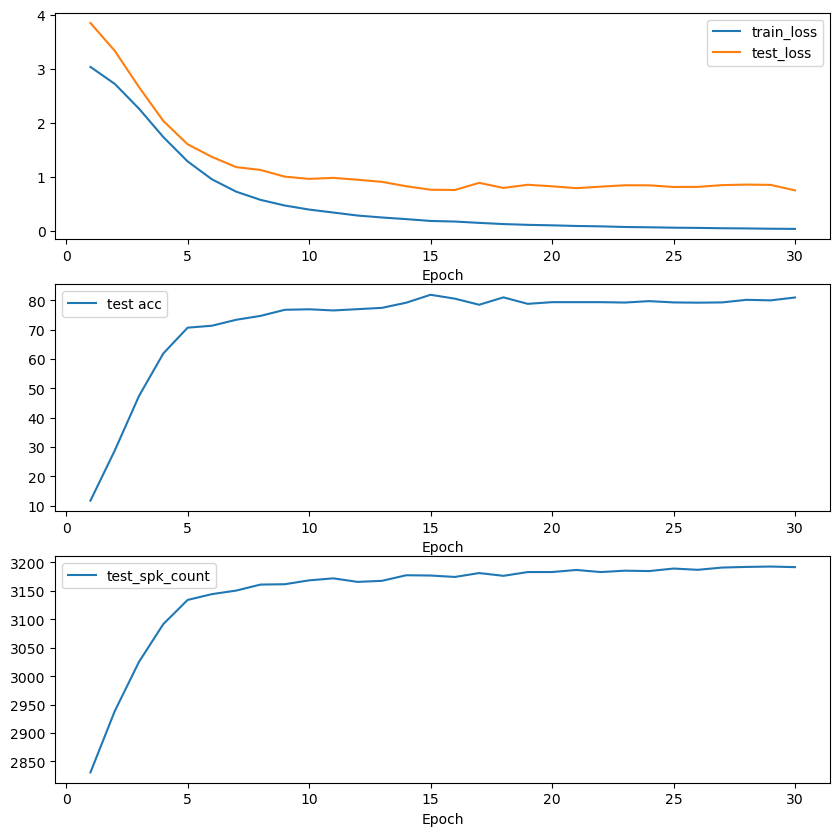

In [2]:
tau_m = 20.0

model_config = [
    {'type': 'Flatten'},
    {
        'type': 'Feedforward', 
        'num_out': 64, # Number of neurons in this dense layer
    },
    {
        'type': 'Feedforward', 
        'num_out': 64, # Number of neurons in this dense layer
        'fanin_delays': {'max_delay': 40, 'stride': 1, 'pruned_delays':3}
    }
]

snn = SNN(dataset_dict=dataset_dict, model_config=model_config,
    tau_m = tau_m, win=total_time, loss_fn='mem_sum', batch_size=batch_size, device=device)

snn.set_layers()
snn.to(device)

print(snn)

num_epochs = 30
lr = 1e-3
ckpt_dir = 'tests'

train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_save_max_last_refact, ckpt_dir=ckpt_dir, scheduler=(100, 0.95), test_every=1)

Delta t: 20.0 ms
SNN(
  (layers): ModuleList(
    (0): FlattenSNNLayer()
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=700, out_features=64, bias=False)
      (tdbn): TDBatchNorm1d(
        (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=2560, out_features=64, bias=False)
      (tdbn): TDBatchNorm1d(
        (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=20, bias=False)
      (tdbn): TDBatchNorm1d(
        (bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (criterion): MSELoss()
)
Epoch [1/30], learning_rates 0.001000, 0.100000
Step [2/7], Loss: 0.05109
Step [4/7], Loss: 0.04960
Step [6/7], Loss: 0.04911
Step [8/7], Loss: 0.04895
Time elasped: 5.586220026016235
2264

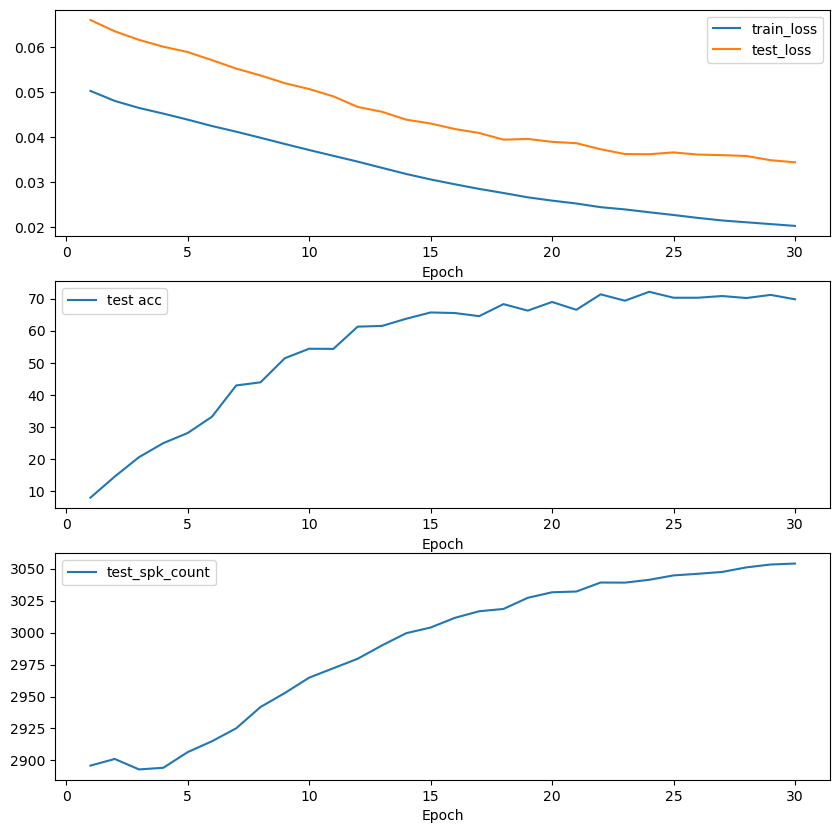

In [3]:
tau_m = 20.0

model_config = [
    {'type': 'Flatten'},
    {
        'type': 'Feedforward', 
        'num_out': 64, # Number of neurons in this dense layer
    },
    {
        'type': 'Feedforward', 
        'num_out': 64, # Number of neurons in this dense layer
        'fanin_delays': {'max_delay': 40, 'stride': 1, 'pruned_delays':3}
    }
]

snn = SNN(dataset_dict=dataset_dict, model_config=model_config,
    tau_m = tau_m, win=total_time, loss_fn='spk_count', batch_size=batch_size, device=device)

snn.set_layers()
snn.to(device)

print(snn)

num_epochs = 30
lr = 1e-3
ckpt_dir = 'tests'

train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_save_max_last_refact, ckpt_dir=ckpt_dir, scheduler=(100, 0.95), test_every=1)

In [4]:
[param for name, param in snn.named_parameters() if 'tdbn' in name]

[Parameter containing:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.], device='cuda:0', requires_grad=True)]